## Project: Artificial Neural Networks- Bank Churn prediction

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

### Dataset Description

1.	RowNumber: Row number.
2.	CustomerId: Unique identification key for different customers.
3.	Surname: Surname of the customer
4.	Credit Score: Credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
5.	Geography: The country to which the customer belongs.
6.	Gender: The gender of the customer.
7.	Age: Age of the customer.
8.	Tenure: The period of time a customer has been associated with the bank.
9.	Balance: The account balance (the amount of money deposited in the bank account) of the customer.
10.	NumOfProducts: How many accounts, bank account affiliated products the person has.
11.	HasCrCard: Does the customer have a credit card through the bank?
12.	IsActiveMember: Subjective, but for the concept
13.	EstimatedSalary: Estimated salary of the customer.
14.	Exited: Did they leave the bank after all?

## Install Tensorflow and import packages

In [1]:
!pip install tensorflow==2.0

In [2]:
from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
%matplotlib inline
import seaborn as sns


In [5]:
#drive.mount('/content/drive')

In [6]:
dataset_file = 'bank.csv'

In [7]:
df = pd.read_csv(dataset_file)

In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We can drop RowNumber, CustomerId and Surname as these fields should have no impact on the churn rate

In [9]:
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)

## Univariate and Bivariate analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [11]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [12]:
df['Geography'].value_counts()  

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Geography has 3 unique values. We can keep this as categorical variable

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [14]:
df['Exited'].value_counts()  

0    7963
1    2037
Name: Exited, dtype: int64

Close to 20% of the customers in the data set exited the bank

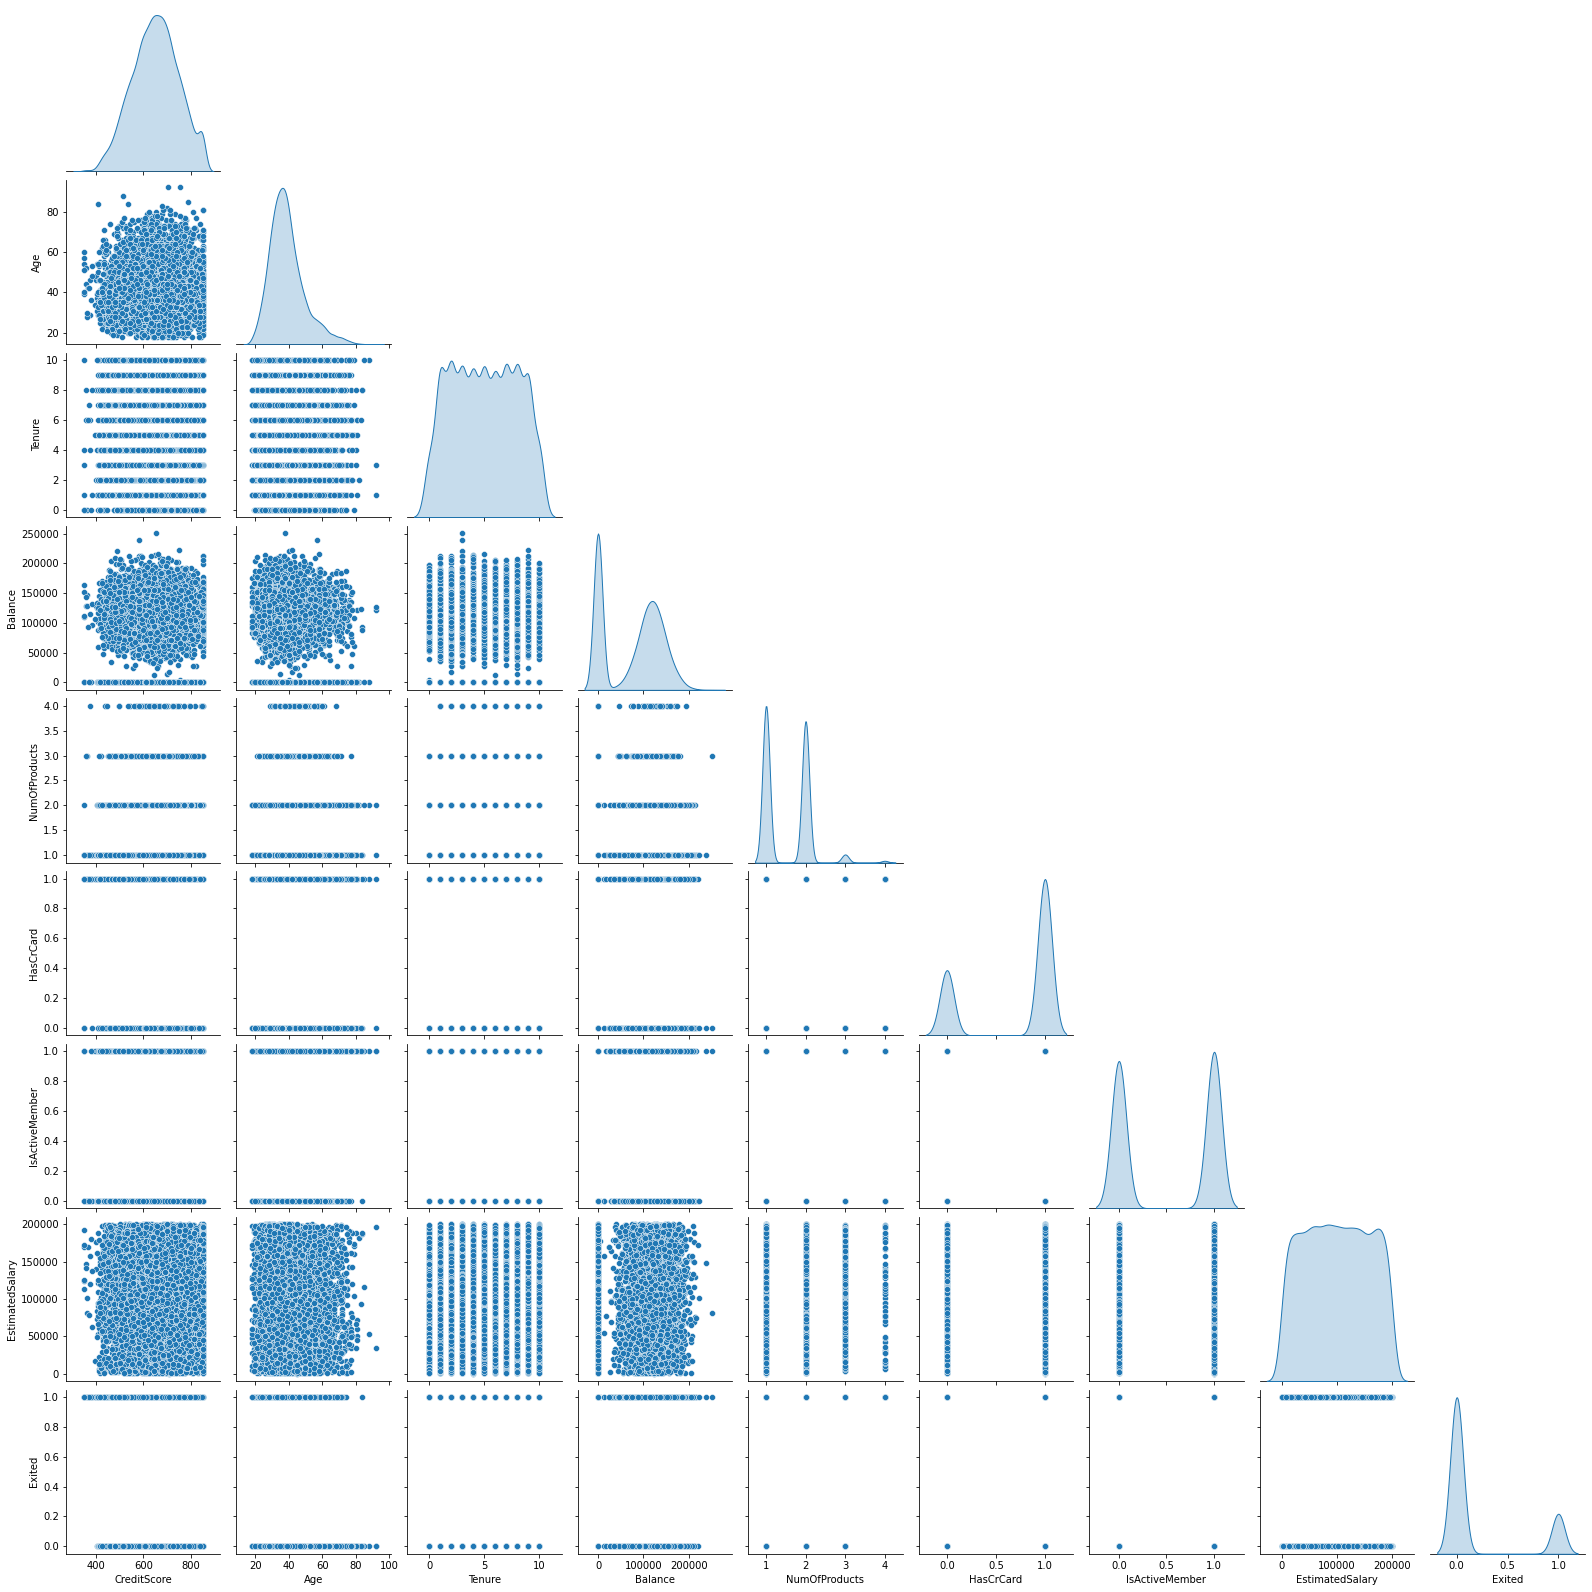

In [15]:
sns.pairplot(df, diag_kind='kde', corner=True) 

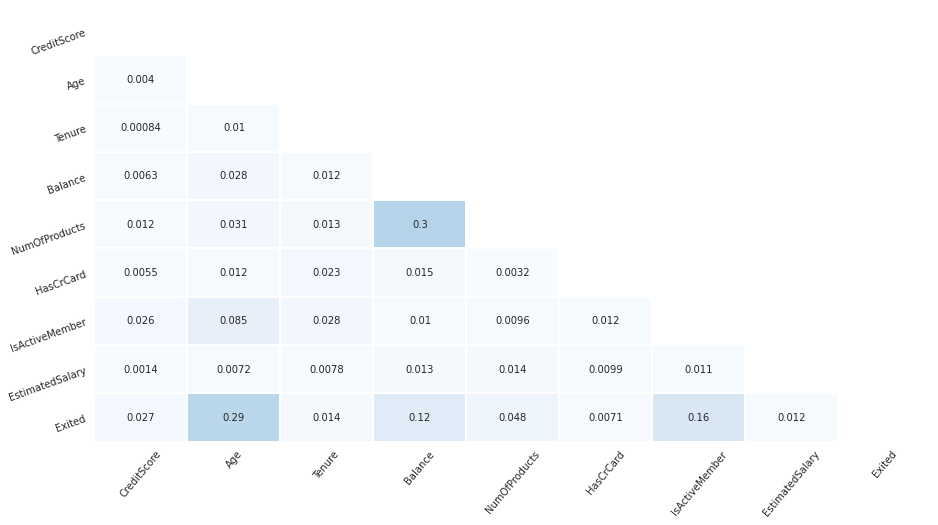

In [16]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 50)  
plt.yticks(rotation = 20)   
plt.show()

### All the variables has correlation with the Churn

In [17]:
df = pd.get_dummies(df, columns=['Geography'])
df = pd.get_dummies(df, columns=['Gender'])
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [18]:
y_data = df['Exited']
df = df.drop('Exited', axis=1)

In [19]:
y_data

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [20]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


### Normalize the X data

In [21]:
from scipy.stats import zscore
df_scaled=df.apply(zscore)
df_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0.997204,-0.578736,-0.573809,1.095988,-1.095988
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.002804,-0.578736,1.742740,1.095988,-1.095988
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0.997204,-0.578736,-0.573809,1.095988,-1.095988
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0.997204,-0.578736,-0.573809,1.095988,-1.095988
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.002804,-0.578736,1.742740,1.095988,-1.095988


In [22]:
df_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,-4.870326e-16,1.00005,-3.109504,-0.688359,0.015222,0.698109,2.063884
Age,10000.0,2.484679e-16,1.00005,-1.994969,-0.660018,-0.183251,0.484225,5.061197
Tenure,10000.0,-1.400324e-16,1.00005,-1.733315,-0.695982,-0.004426,0.687130,1.724464
Balance,10000.0,-5.978551e-17,1.00005,-1.225848,-1.225848,0.331964,0.819920,2.795323
NumOfProducts,10000.0,-8.652634e-16,1.00005,-0.911583,-0.911583,-0.911583,0.807737,4.246377
HasCrCard,10000.0,-2.676082e-16,1.00005,-1.547768,-1.547768,0.646092,0.646092,0.646092
IsActiveMember,10000.0,2.164047e-16,1.00005,-1.030670,-1.030670,0.970243,0.970243,0.970243
EstimatedSalary,10000.0,-1.580958e-17,1.00005,-1.740268,-0.853594,0.001803,0.857243,1.737200
Geography_France,10000.0,7.723266e-16,1.00005,-1.002804,-1.002804,0.997204,0.997204,0.997204
Geography_Germany,10000.0,5.961232e-16,1.00005,-0.578736,-0.578736,-0.578736,1.727904,1.727904


In [23]:
y_data

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

In [24]:
X_data = df_scaled.iloc[:, :]

In [25]:
X_data.shape

(10000, 13)

In [26]:
X_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0.997204,-0.578736,-0.573809,1.095988,-1.095988
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.002804,-0.578736,1.742740,1.095988,-1.095988
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0.997204,-0.578736,-0.573809,1.095988,-1.095988
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0.997204,-0.578736,-0.573809,1.095988,-1.095988
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.002804,-0.578736,1.742740,1.095988,-1.095988


In [27]:
y_data.shape

(10000,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


# AI Model Creation

In [30]:
model = Sequential()


In [31]:
model.add(Dense(64, input_shape = (13,), activation = 'relu'))
model.add(Dense(32, activation = 'tanh'))
#model.add(Dense(64, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
sgd = optimizers.Adam(lr = 0.001)

In [33]:
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [35]:
model.fit(X_train, y_train.values, batch_size = 700, epochs = 100, verbose = 1)

Train on 8000 samples
Epoch 1/100
8000/8000 [==============================] - 0s 10us/sample - loss: 0.5549 - accuracy: 0.7479
Epoch 2/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4788 - accuracy: 0.7965
Epoch 3/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4578 - accuracy: 0.7975
Epoch 4/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4442 - accuracy: 0.8055
Epoch 5/100
8000/8000 [==============================] - 0s 5us/sample - loss: 0.4362 - accuracy: 0.8098
Epoch 6/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4298 - accuracy: 0.8117
Epoch 7/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4243 - accuracy: 0.8155
Epoch 8/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4189 - accuracy: 0.8181
Epoch 9/100
8000/8000 [==============================] - 0s 4us/sample - loss: 0.4134 - accuracy: 0.8209
Epoch 10/100
8000/8000 [========

In [36]:
results = model.evaluate(X_test, y_test)


2000/2000 [==============================] - 0s 25us/sample - loss: 0.3433 - accuracy: 0.8555


In [37]:
print(model.metrics_names)
print(results)    

['loss', 'accuracy']
[0.34330374336242675, 0.8555]


### Confusion Matrix

In [38]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)

2000/2000 [==============================] - 0s 20us/sample - loss: 0.3433 - accuracy: 0.8555
Accuracy Model1 (Dropout): 0.8555
Recall_score: 0.5231143552311436
Precision_score: 0.698051948051948
F-score: 0.5980528511821974


array([[1496,   93],
       [ 196,  215]])

In [39]:
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted, [1,0] )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Exited", "Not Exited"] , yticklabels = ["Exited", "Not Exited"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

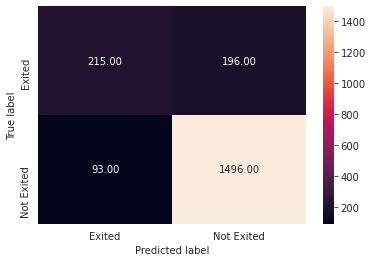

In [40]:
draw_cm( y_test, Y_pred_cls )

# Conclusion

1.   We got an accuracy of 85% with the AI model
2.   The accuracy is reasonable since we have all 10,000 data records. This is not sifficient for an AI model to have better accuracy

